# Importing necessary libraries

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from scipy.ndimage import filters
import matplotlib.pyplot as plt
import random
from scipy import linalg
import sys
import math

# harris corner detector

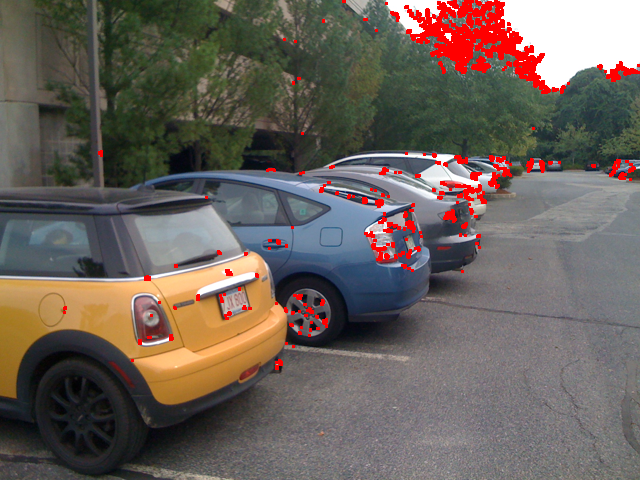

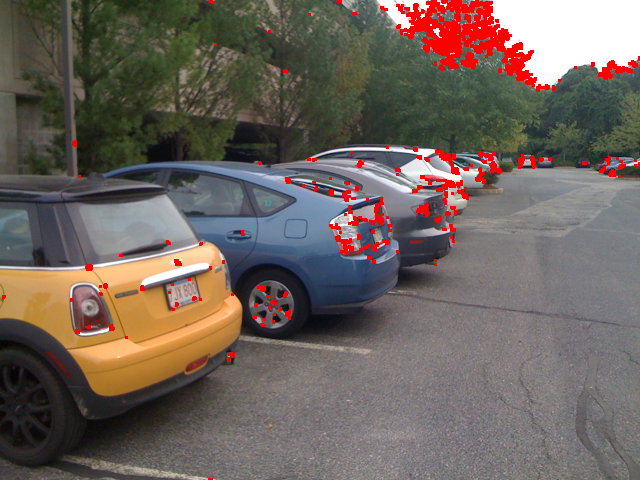

In [ ]:



img1 = 'parkinglot_left.pnm'
img2 = 'parkinglot_right.pnm'
img1 = cv2.imread(img1)
img2 = cv2.imread(img2)
gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
gray1 = np.float32(gray1)
gray2 = np.float32(gray2)

dst1 = cv2.cornerHarris(gray1,2,3,0.04)
dst2 = cv2.cornerHarris(gray2,2,3,0.04)
#result is dilated for marking the corners, not important
dst1 = cv2.dilate(dst1,None)
dst2 = cv2.dilate(dst2,None)
# Threshold for an optimal value, it may vary depending on the image.
img1[dst1>0.01*dst1.max()]=[0,0,255]
img2[dst2>0.01*dst2.max()]=[0,0,255]

cv2_imshow(img1)
cv2_imshow(img2)
if cv2.waitKey(0) & 0xff == 27:
    cv2.destroyAllWindows()

# Similarity measure using NCC

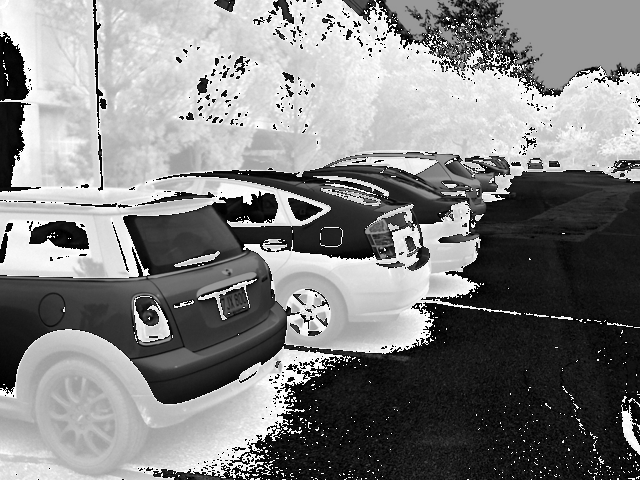

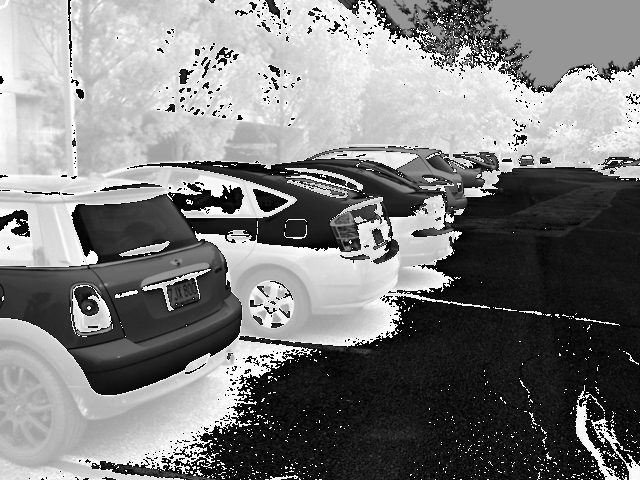

In [ ]:
# Load the two images
img1 = cv.imread('parkinglot_left.pnm', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('parkinglot_right.pnm', cv.IMREAD_GRAYSCALE)

# Define the window size for NCC
win_size = 15

# Compute the mean and standard deviation of the two images
mean1, std1 = cv.meanStdDev(img1)
mean2, std2 = cv.meanStdDev(img2)

mean1 = round(mean1[0][0])
mean2 = round(mean2[0][0])
std1 = round(std1[0][0])
std2 = round(std2[0][0])

# Subtract the mean from the images
img1 -= mean1
img2 -= mean2

# Compute the normalized cross-correlation (NCC) between the two images
corr = cv.matchTemplate(img1, img2, cv.TM_CCORR_NORMED)

# Find the peak locations of the NCC
peaks = np.where(corr >= 0.8)

# Loop over the peak locations and draw circles on both images to visualize the correspondences
for i in range(len(peaks[0])):
    y, x = peaks[0][i], peaks[1][i]
    cv.circle(img1, (x, y), win_size // 2, (255, 0, 0), 2)
    cv.circle(img2, (x, y), win_size // 2, (255, 0, 0), 2)

# Display the images with correspondences
cv2_imshow(img1)
cv2_imshow(img2)
cv.waitKey(0)
cv.destroyAllWindows()

#Fundamental matrix computation and display epipolar lines

In [ ]:

sigma=1.4
harris_k=0.06
harris_threshold=0.03
harris_mindist=8
NCC_threshold=0.99
NCC_windodim=8
RANSAC_times=1000
F_inliner_threshold=1
e_line_number=100
SIFT_threshold=0.75

def converttogray(l_m,r_m):
    gray_left = cv2.cvtColor(l_m, cv2.COLOR_BGR2GRAY)
    gray_right = cv2.cvtColor(r_m, cv2.COLOR_BGR2GRAY)
    return gray_left,gray_right


def SIFTcorner(img1,img2,min_dist,SIFT_threshold):
    sift = cv2.xfeatures2d.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    filtered_coords1 = []
    filtered_coords2 = []
    good = []
    for k1 in kp1:
        filtered_coords1.append(np.array([k1.pt[1],k1.pt[0]],dtype='int64'))
    for k2 in kp2:
        filtered_coords2.append(np.array([k2.pt[1],k2.pt[0]],dtype='int64'))
    for m, n in matches:
        if m.distance < SIFT_threshold * n.distance:
            good.append([m.queryIdx,m.trainIdx])
    return filtered_coords1,filtered_coords2,good


def harriscorner(im,threshold,min_dist):
    #get derivate
    imx = np.zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (0, 1), imx)
    imy = np.zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (1, 0), imy)
    #find wxx,wxy,wyy
    Wxx = filters.gaussian_filter(imx * imx, sigma)
    Wxy = filters.gaussian_filter(imx * imy, sigma)
    Wyy = filters.gaussian_filter(imy * imy, sigma)
    # determinant and trace
    Wdet = Wxx * Wyy - Wxy ** 2
    Wtr = Wxx + Wyy
    harrisim=Wdet/Wtr

    conner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > conner_threshold) * 1
    coords = np.array(harrisim_t.nonzero()).T
    candidate_values = [harrisim[c[0], c[1]] for c in coords]
    index = np.argsort(candidate_values)
    allowed_locations = np.zeros(harrisim.shape)
    # non_maximum suppression
    allowed_locations[min_dist:-min_dist, min_dist:-min_dist] = 1
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i, 0], coords[i, 1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i, 0] - min_dist):(coords[i, 0] + min_dist),
            (coords[i, 1] - min_dist):(coords[i, 1] + min_dist)] = 0
    #print(filtered_coords)
    return filtered_coords


def getNCC(leftwindow,rightwindow):
    N_L=sum(sum(leftwindow**2))**(1/2)
    N_R = sum(sum(rightwindow ** 2)) ** (1 / 2)
    ncc=sum(sum((leftwindow/N_L)*(rightwindow/N_R)))
    return ncc


def matchpoints(gray_left,gray_right,leftcorner,rightcorner,windowsize,threshold):
    m=len(leftcorner)
    n=len(rightcorner)
    gray_left=np.array(gray_left,dtype='uint32')
    gray_right=np.array(gray_right,dtype='uint32')
    NCC_value=np.zeros((m,n))
    for i in range (m):
        leftwindow = gray_left[(leftcorner[i][0] - windowsize):(leftcorner[i][0] + windowsize + 1),
                     (leftcorner[i][1] - windowsize):(leftcorner[i][1] + windowsize + 1)]
        for j in range(n):
            rightwindow=gray_right[(rightcorner[j][0]-windowsize):(rightcorner[j][0]+windowsize+1),(rightcorner[j][1]-windowsize):(rightcorner[j][1]+windowsize+1)]
            NCC_value[i,j]=getNCC(leftwindow,rightwindow)
    ncc=NCC_value.tolist()
    matches=[]
    for i in range (m*n):
        m_max = []
        for j in range (m):
            m_max.extend([max(ncc[j])])
        temp=max(m_max)
        if temp<threshold:
            break
        for a in range (m):
            for b in range(n):
                if ncc[a][b]==temp:
                    matches += [[a,b]]
                    ncc[a][b] = 0
                    a=m+1
                    b=n+1
                    break
    return matches

def drawmatchpointimage(image1,image2,kpl,kpr,matches,linenumber):
    #res = cv2.drawMatches(img1_gray,kpl, img2_gray, kpr, matches[:40], None, flags=2)
    width = image1.shape[1] + image2.shape[1]
    height = max(image1.shape[0], image2.shape[0])
    image = np.zeros([height, width,3], dtype='uint8')
    for i in range(0, width):
        for j in range(0, height):
            if i < ((image.shape[1] / 2) - 1):
                image[j][i] = image1[j][i]
                x=i
            else:
                image[j][i] = image2[j][i-x-2]
    #cv2.imwrite(path + name + '.jpg', image)
    plt.ion()
    plt.imshow(image,cmap='gray')
    #plt.plot([p[1] for p in kpl], [p[0] for p in kpl], '+')
    #plt.plot([p[1]+image1.shape[1] for p in kpr], [p[0] for p in kpr], '+')
    for a in range(0, linenumber):
        temp_l=matches[a][0]
        temp_r=matches[a][1]
        plt.plot(kpl[temp_l][1],kpl[temp_l][0],'+')
        plt.plot(kpr[temp_r][1]+image1.shape[1],kpr[temp_r][0],'+')
        plt.plot([kpl[temp_l][1],kpr[temp_r][1]+image1.shape[1]],[kpl[temp_l][0],kpr[temp_r][0]])

    plt.ioff()
    plt.show()
    return 0


def drawinliners(image1,image2,cor_l,cor_r,ncc_match,F,threshold):
    inliners=[]
    draw_p=len(ncc_match)
    if draw_p>=40:
        draw_p=40
    for c in range (draw_p):
      p_l = []
      p_l.extend([cor_l[ncc_match[c][0]]])
      p_l = np.append(p_l, 1)
      p_r = []
      p_r.extend([cor_r[ncc_match[c][1]]])
      p_r = np.append(p_r, 1)
      if np.dot(np.dot(p_l,F),p_r)<threshold:
          inliners+=[ncc_match[c]]
    print(len(inliners))
    drawmatchpointimage(image1,image2,cor_l,cor_r,inliners,len(inliners))
    return


def findFmatrix(x1,x2,n):
    x1=np.array(x1)
    x2=np.array(x2)
    A = np.zeros((n, 9))
    for i in range(n):
        A[i] = [x1[i, 1] * x2[i, 1], x1[i, 1] * x2[i, 0], x1[i, 1],
                x1[i, 0] * x2[i, 1], x1[i, 0] * x2[i, 0], x1[i, 0],
                x2[i, 1], x2[i, 0], 1]
    # compute linear least square solution
    U, S, V = linalg.svd(A)
    F = V[-1].reshape(3, 3)
    # constrain F
    U, S, V = linalg.svd(F)
    S[2] = 0
    F = np.dot(U, np.dot(np.diag(S), V))
    return F / F[2, 2]


def theransanc(ransactimes,cor_l,cor_r,ncc_match):
    ACC_result=sys.maxsize
    F_result=None
    ransanc_num=50
    for a in range(ransactimes):
        p1=[]
        p2=[]
        for b in range(ransanc_num):
          temp=random.randint(0, len(ncc_match)-1)
          p1.extend([cor_l[ncc_match[temp][0]]])
          p2.extend([cor_r[ncc_match[temp][1]]])
        F=findFmatrix(p1,p2,ransanc_num)
        temp1=0
        for c in range(len(ncc_match)):
            p_l=[]
            p_l.extend([cor_l[ncc_match[c][0]]])
            p_l=np.append(p_l,1)
            p_r = []
            p_r.extend([cor_r[ncc_match[c][1]]])
            p_r = np.append(p_r, 1)
            temp1+=abs(np.dot(np.dot(p_l.T,F),p_r))
        if temp1<ACC_result:
            ACC_result=temp1
            F_result=F
            #print([a,ACC_result])
    return F_result


def calculateepipole(point,F,m,n,linepoints):
    e_line=np.dot(F,point.T)
    t = np.linspace(NCC_windodim, n-NCC_windodim-1, linepoints)
    lt = np.array([(e_line[2] + e_line[0] * tt) / (-e_line[1]) for tt in t])
    ndx = (lt >= 0) & (lt < m)
    t = np.reshape(t, (linepoints, 1))
    return t[ndx],lt[ndx]


def drawepipole(image1,image2,point,F):
    m, n= image2.shape
    width = image1.shape[1] + image2.shape[1]
    height = max(image1.shape[0], image2.shape[0])
    image = np.zeros([height, width, 3], dtype='uint8')
    for i in range(0, width):
        for j in range(0, height):
            if i < ((image.shape[1] / 2) - 1):
                image[j][i] = image1[j][i]
                x = i
            else:
                image[j][i] = image2[j][i - x - 2]
    line_x,line_y=calculateepipole(point,F,m,n,e_line_number)
    plt.ion()
    plt.imshow(image)
    plt.plot(point[1],point[0],'+')
    plt.plot(line_x+n, line_y, linewidth=2)
    plt.ioff()
    plt.show()

def main():
    #readinimage
    leftimage = cv2.imread('parkinglot_left.pnm')  # queryImage
    rightimage = cv2.imread('parkinglot_right.pnm') # trainImage
    gray_left,gray_right=converttogray(leftimage,rightimage)
    #match key_points
    cor_l,cor_r,ncc_match=SIFTcorner(gray_left,gray_right,harris_mindist,SIFT_threshold)
    # cor_l=harriscorner(gray_left,harris_threshold,harris_mindist)
    # cor_r=harriscorner(gray_right,harris_threshold,harris_mindist)
    print([len(cor_l),len(cor_r)])
    # ncc_match=matchpoints(gray_left,gray_right,cor_l,cor_r,NCC_windodim,NCC_threshold)
    print(len(ncc_match))
    #drawmatchpointimage(leftimage,rightimage,cor_l,cor_r,ncc_match,50)
    # #8-point and RANSAC solve F matrix
    F=theransanc(RANSAC_times,cor_l,cor_r,ncc_match)
    drawinliners(leftimage,rightimage,cor_l,cor_r,ncc_match,F,F_inliner_threshold)
    # # #compute dense disparity map
    expoint=[100,200,1]
    expoint=np.array(expoint)
    drawepipole(gray_left,gray_right,expoint,F)

[1027, 1058]
478
40


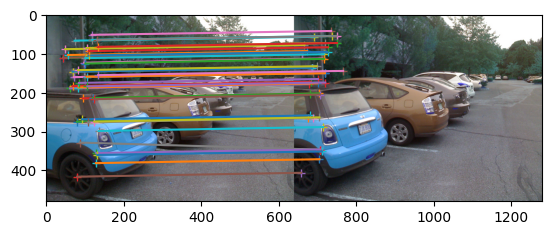

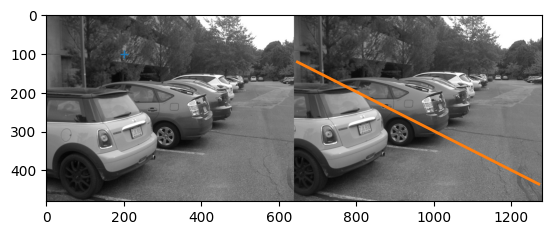

In [ ]:
main()